# GM仮定４が満たされない場合

If you come here without expecting Japanese, please click [Google translated version](https://translate.google.com/translate?hl=&sl=ja&tl=en&u=https%3A%2F%2Fpy4etrics.github.io%2F18_Zero_Conditional_Mean.html) in English or the language of your choice.

---

In [1]:
from scipy.stats import multivariate_normal, norm, uniform
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from numba import njit

## 説明

仮定４：Zero conditional mean $\text{E}\left(u|X\right)=0$

* この仮定が満たされない場合，`OLS`推定量は不偏性・一致性が満たされない。
* 経済学の実証分析では，この仮定が満たされない場合が多々ある。その主な理由に次の３つが挙げられる。
    * 欠落変数
    * 測定誤差
    * 同時方程式

以下ではこの３つについて説明し，シミュレーションで発生するバイアスを確認する。

その前に，仮定４が満たされる場合と満たされない場合の違いをシミュレーションを通して直感的に理解する。

## シミュレーション

### 準備

パラメータの真の値を設定する。

In [2]:
b0=1.0
b1=1.0

シミュレーションの関数を作成

In [3]:
def sim_a4(n, m):  # n=標本の大きさ, m=共分散
    
    rv_mean = [4, 0]  # x, uの平均
    rv_cov = [[1.0, m],   # x, uの共分散行列
               [m, 0.1]]  # Cov(x,u)=m
    
    rv = multivariate_normal.rvs(rv_mean, rv_cov, size=n)  # x1, uをnセット抽出
    x = rv[:,0]  # 説明変数
    u = rv[:,1]  # 誤差項
    y = b0 + b1*x + u  # 説明変数

    df = pd.DataFrame({'Y':y, 'X':x})  # DataFrameの作成
    res = ols(formula='Y ~ X', data=df).fit()  # OLS推定

    return x, y, u, res.params[0], res.params[1] # 返り値の設定

ここで重要な役割を果たすのが説明変数と誤差項の共分散を表す`m`である。

### 仮定４が満たされる場合：$m=0$

In [4]:
x_0, y_0, u_0, b0hat_0, b1hat_0 = sim_a4(100, m=0)

母集団の誤差項$u$と説明変数$x$

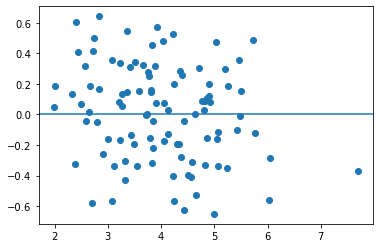

In [5]:
plt.scatter(x_0,u_0)
plt.axhline(0)
pass

共分散を計算してみよう。

In [6]:
np.corrcoef(x_0,u_0)

array([[ 1.        , -0.22076925],
       [-0.22076925,  1.        ]])

共分散は非常に小さな数字であり，特定な傾向がない。次に，母集団回帰直線とOLS回帰直線を比べてみる。

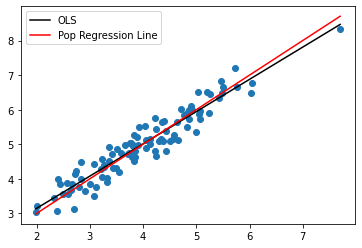

In [7]:
xx = np.linspace(min(x_0),max(x_0),100)

plt.scatter(x_0,y_0)
plt.plot(xx,b0hat_0+b1hat_0*xx, 'k', label='OLS')
plt.plot(xx,b0+b1*xx,'r', label='Pop Regression Line')
plt.legend()
pass

推定量が不偏性を満たしているため両方は殆ど同じである。

### 仮定４が満たされない場合：$m\neq 0$

In [8]:
x_1, y_1, u_1, b0hat_1, b1hat_1 = sim_a4(100, m=0.25)

母集団の誤差項$u$と説明変数$x$を図示しよう。

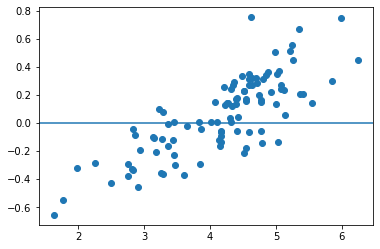

In [9]:
plt.scatter(x_1,u_1)
plt.axhline(0)
pass

In [10]:
np.corrcoef(x_1,u_1)

array([[1.       , 0.7951578],
       [0.7951578, 1.       ]])

強い正の共分散が確認できる。母集団回帰線とOLS回帰直線を比べる。

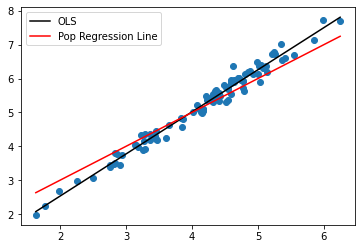

In [11]:
xx = np.linspace(min(x_1),max(x_1),100)

plt.scatter(x_1,y_1)
plt.plot(xx,b0hat_1+b1hat_1*xx, 'k', label='OLS')
plt.plot(xx,b0+b1*xx, 'r', label='Pop Regression Line')
plt.legend()
pass

明らかに異なる。GM仮定４が満たされず，推定量の不偏性が満たされないためである。この場合，一致性も満たされない。標本の大きさ`n`を`100000`にして確かめてみる。

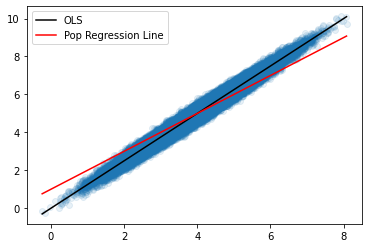

In [12]:
x_1, y_1, u_1, b0hat_1, b1hat_1 = sim_a4(100_000, m=0.25)

xx = np.linspace(min(x_1),max(x_1),100)

plt.scatter(x_1,y_1, alpha=0.1)  # 下の説明を参照
plt.plot(xx,b0hat_1+b1hat_1*xx, 'k', label='OLS')
plt.plot(xx,b0+b1*xx,'r', label='Pop Regression Line')
plt.legend()
pass

上から３行目に`alpha=0.1`とあるが，散布図のマーカーの透明度をしている引数であり`0~1`の値をとる。デフォルトは`1`であり，`0`は透明になる。

## 欠落変数

### 欠落変数バイアス

母集団のモデルは以下で与えられるとしよう。

$$y=\beta_0+\beta_1 x_1+\beta_2x_2+\beta_3x_3+u\qquad\quad(\text{母集団モデル})$$

実際に推定されるモデル（$x_3$が欠落）：

$$y=\gamma_0+\gamma_1 x_1+\gamma_2x_2+\eta\qquad\quad(\text{推定モデル})$$

更に，$x_1$と$x_3$には以下の関係があると仮定する。

$$x_3=\delta_0+\delta_1 x_1+\epsilon\qquad\quad(\text{仮定})$$

この式を母集団モデルに代入すると：

$$y=(\beta_0+\beta_3\delta_0)+(\beta_1+\beta_3\delta_1)x_1+\beta_2x_2+\tilde{\eta}$$

ここで，$\tilde{\eta}\equiv\beta_3\epsilon+u$。推定モデルはこの関係に基づいて係数を計算することになる。

**（結果１）**

推定モデルを使うと
* $\hat{\gamma}_0$は$\beta_0+\beta_3\delta_0$の推定値
* $\hat{\gamma}_1$は$\beta_1+\beta_3\delta_1$の推定値
* $\hat{\gamma}_2$は$\beta_2$の推定値

となり$\gamma_0$と$\gamma_1$の推定値にバイアスが発生する。一方，$\hat{\gamma}_2$にはバイアスは発生しない。欠落変数と無相関の変数（定数以外）にはバイアスは発生しないためである。

**（結果２）**
* 欠落変数が回帰式の説明変数と無相関であれば，バイアスは発生しない！

**（理由）**

GM仮定４が満たされていないため。母集団モデル，推定モデルと仮定の式から

$$
\eta=\beta_3x_3+u=\beta_3(\delta_0+\delta_1x_1+\epsilon)+u
\quad\Rightarrow\quad
\tilde{\eta}=\eta-\beta_3(\delta_0+\delta_1x_1)
$$

これから$x_1$と$\tilde{\eta}$は相関することがわかる。

### シミュレーション１：推定値の計算

One-shotのシミュレーションをおこないバイアスの発生を確認する。

In [13]:
# 母集団のパラメータ
b0 = 1
b1 = 1
b2 = 1
b3 = 1

# 標本数
n = 1000

# 説明変数　x1, x2
x1 = np.random.normal(4, 1, size=n)
x2 = np.random.uniform(1, 10, size=n)

# 説明変数　x3
e = np.random.normal(size=n)
m = 2.0  # x1との相関性を捉える
x3 = 1 + m*x1 + e

# 母集団の誤差項
u = np.random.normal(size=n)
y = b0 + b1*x1 + b2*x2 + b3*x3 + u

# 標本のDataFrame
df_sample = pd.DataFrame({'Y':y, 'X1':x1, 'X2':x2, 'X3':x3})

# 推定
formula_omitted = 'Y ~ X1 + X2'
res_omitted = ols(formula_omitted, data=df_sample).fit()
res_omitted.params

Intercept    2.371660
X1           2.937817
X2           0.979455
dtype: float64

`X1`のパラメータの値は真の値と明らかに異なる。

### シミュレーション２：推定値の分布

`OLS`推定量の分布を確認する。

In [14]:
# 母集団のパラメータの値
b0 = 1
b1 = 1
b2 = 1
b3 = 1

# シミュレーションの回数
N = 10_000

シミュレーションの関数を設定する。
* 引数：
    * `n`：標本の大きさ
    * `m`：`x1`と`x3`の相関を捉えるパラメータ
* 戻り値：推定値のリスト

In [15]:
@njit
def sim_omitted(n,m):

    # 空のリスト
    b0hat_arr = np.zeros(N)
    b1hat_arr = np.zeros(N)
    b2hat_arr = np.zeros(N)

    # 説明変数
    x1 = np.random.normal(loc=4, scale=1, size=n)
    x2 = np.random.uniform(1, 10, size=n)
    e = np.random.normal(loc=0, scale=1, size=n)
    x3 = 1 + m*x1 + e
    
    c = np.ones(n)  # 定数項
    
    for i in range(N):  # N回のループ
        # 母集団
        u = np.random.normal(loc=0, scale=1, size=n)
        y = b0 + b1*x1 + b2*x2 + b3*x3 + u
        
        X = np.stack((c,x1,x2), axis=1)  # 説明変数の行列
        bhat = np.linalg.inv((X.T)@X)@(X.T)@y  # OLS推定
        
        b0hat_arr[i] = bhat[0]
        b1hat_arr[i] = bhat[1]
        b2hat_arr[i] = bhat[2]

    return b0hat_arr, b1hat_arr, b2hat_arr

シミュレーションの開始

In [16]:
b0hat, b1hat, b2hat = sim_omitted(1000,m=2.0)

$\hat{\beta}_0$の分布

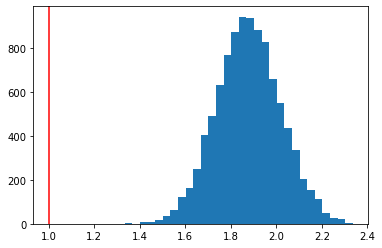

In [17]:
plt.hist(b0hat, bins=30)
plt.axvline(x=b0, color='red')
pass

$\hat{\beta}_1$の分布

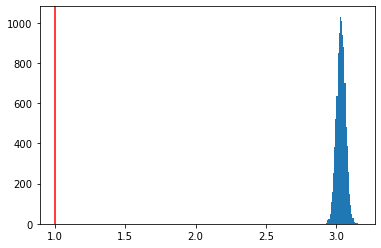

In [18]:
plt.hist(b1hat, bins=30)
plt.axvline(x=b1, color='red')
pass

$\hat{\beta}_2$の分布

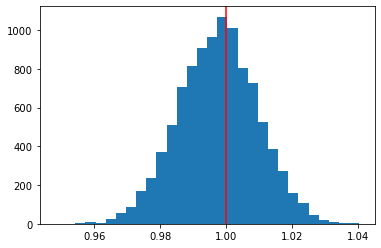

In [19]:
plt.hist(b2hat, bins=30)
plt.axvline(x=b2, color='red')
pass

## 測定誤差

### 測定誤差によるバイアス

次の母集団回帰式を考えよう。

$$y=\beta_0+\beta_1 x^* + \eta$$

ここで，被説明変数$y$は正確に測定できるが，説明変数$x^*$は以下の式に従って測定される仮定する。

$$x=x^*+e$$

* $x$：測定値
* $e$：測定誤差

（仮定）

* 測定誤差$e$は真の値と無関係。即ち，$\text{Cov}(x^*,e)=0$

（結果）

* 次式をOLS推定する場合，$\hat{\beta}_1$は不偏性・一致性を満たさない。

$$y=\beta_0+\beta_1 x + u,\qquad u=\eta-\beta e$$

（理由）

仮定４：$\text{Cov}(x,u)=0$が満たされない。

$$
\text{Cov}(x,u)=\text{E}[xu]
=\text{E}\left[(x^*+e)(\eta-\beta e)\right]
=-\beta\cdot\text{E}(e^2)>0
$$

### シミュレーション１：推定値の計算

One-shotのシミュレーションをおこないバイアスの発生を確認する。

In [20]:
# 標本の大きさ
n = 100

# 母集団回帰式
b0 = 1.0
b1 = 1.0
x_pop = np.random.uniform(1,10,size=n)  # 母集団の説明変数
u = np.random.normal(scale=1, size=n)  # 母集団の誤差項
y = b0 + b1*x_pop + u  # 母集団回帰式

# 測定誤差
error_sd = 3  # 測定誤差の標準偏差
x = x_pop + np.random.normal(scale=error_sd, size=n)  # 測定誤差

# OLS推定
df_sim = pd.DataFrame({'Y':y, 'X':x})  # DataFrameの作成
res_ols = ols('Y ~ X', data=df_sim).fit()  # OLS推定

res_ols.params  # OLS推定量

Intercept    4.045152
X            0.427538
dtype: float64

### シミュレーション２：推定値の分布

`OLS`推定量の分布を確認する。

In [21]:
# 真のパラメータ
b0 = 1.0
b1 = 1.0

# シミュレーションの回数
N = 100_000

In [22]:
@njit
def sim_measure(n):
    
    b0hat_arr = np.zeros(N)
    b1hat_arr = np.zeros(N)

    x_pop = np.random.uniform(1,10,size=n)  # 母集団の説明変数
    
    c = np.ones(n)  # 定数項
        
    # 説明変数の測定誤差
    error_sd = 3  # 測定誤差の標準偏差
    x = x_pop + np.random.normal(loc=0, scale=error_sd, size=n)  # 測定誤差

    for i in range(N):
        u = np.random.normal(loc=0, scale=1, size=n)  # 母集団の誤差項
        y = b0 + b1*x_pop + u  # 母集団回帰式
        
        X = np.stack((c,x), axis=1)  # 説明変数の行列
        bhat = np.linalg.inv((X.T)@X)@(X.T)@y  # OLS推定
        
        b0hat_arr[i] = bhat[0]
        b1hat_arr[i] = bhat[1]

    return b0hat_arr, b1hat_arr

シミュレーションの開始

In [23]:
b0hat, b1hat = sim_measure(100)

$\hat{\beta}_0$の分布

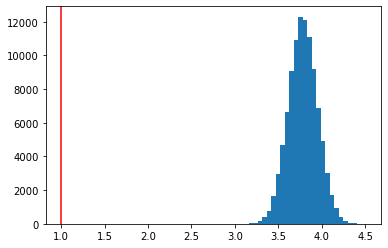

In [24]:
plt.hist(b0hat,bins=30)
plt.axvline(x=b0,color='red')
pass

$\hat{\beta}_1$の分布

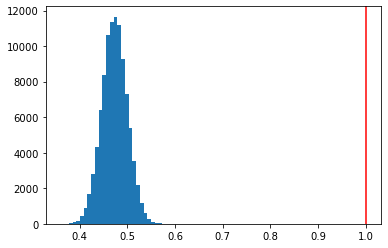

In [25]:
plt.hist(b1hat,bins=30)
plt.axvline(x=b1,color='red')
pass

## 同時方程式

### 同時性バイアス

同時方程式モデルとは，均衡メカニズムなどを通して複数の内生変数が複数の式によって同時決定されるモデルである。例として労働の需給モデルを考えよう。均衡では需要量（$L_d$）と供給量（$L_s$）は等しくなり（$L=L_d=L_s$），需要と供給はそれぞれ均衡賃金（$W$）に依存する。
* 労働供給関数

    $$ L = s_0+s_1 W + s_2 X_s + u_s\qquad\qquad\qquad\text{(式１)}$$

    * $s_1>0$
    * $X_s=$ 供給の「その他」の決定要因（例えば，所得水準）
    * $u_s=$ 供給の誤差項

* 労働需要関数

    $$ W = d_0+d_1 L + d_2 X_d + u_d\qquad\qquad\qquad\text{(式２)}$$
        
    * $d_1<0$
    * $X_d=$ 需要の「その他」の決定要因（例えば，教育水準）
    * $u_d=$ 需要の誤差項

（相関性の仮定）
* $\text{Cov}(X_s,u_s)=\text{Cov}(X_d,u_d)=\text{Cov}(u_s,u_d)=0$

上の式は**構造方程式（structural equations）**
と呼ばれる。これらの式を直接推定するとOLS推定量にはバイアスが発生する。理由は，供給関数では$\text{Cov}(W,u_s)\neq 0$となり需要関数でも$\text{Cov}(L,u_d)\neq 0$となるためである。即ち，仮定４が満たされないのである。この結果は簡単に示すことができる。２つの式を同時方程式として$L$と$W$の解を計算すると次式を得る。

$$L=\alpha_0+\alpha_1X_d+\alpha_2X_s+\frac{s_1u_d+u_s}{1-d_1s_1}\qquad\qquad\qquad\text{(式３)}$$

$$W=\beta_0+\beta_1X_d+\beta_2X_s+\frac{d_1u_s+u_d}{1-d_1s_1}\qquad\qquad\qquad\text{(式４)}$$

ここで$\alpha_i$,$\beta_i$,$i=0,1,2$は$d_i$,$s_i$,$i=0,1,2$の非線形な形をとることになる。
このような$L$と$W$の解の式は**誘導型方程式（reduced-form equations）**
と呼ばれるが，この式から次の点は明らかである。
* （式３）：$L$は$u_d$に依存し，$L$と$u_d$は相関する　$\Rightarrow$　$\text{Cov}(L,u_d)\neq 0$
* （式４）：$W$も$u_s$に依存し，$W$と$u_s$は相関する　$\Rightarrow$　$\text{Cov}(W,u_s)\neq 0$

では誘導型方程式を推定すればどうなるのか？相関性の仮定のもと$\hat{\alpha}_i$,$\hat{\beta}_i$,$i=0,1,2$は不偏性・一致性を保持する。しかし問題は，誘導型方程式を満たす構造方程式は無数にあり，その推定値から$d_i$,$s_i$,$i=0,1,2$を復元できないのである。従って，それらのパラメータの値を推定するためには(式１)と(式２)を推定する必要がある。

### シミュレーション１：推定値の計算

（目的）

One-shotのシミュレーションをおこない構造方程式を直接推定すると推定値にバイアスが発生することを確認する。

シミュレーションの簡単化のために(式２)の中で$s_2=0$を仮定する。これにより，(式３)と(式４)のパラメータは以下で与えられる。

$$
\alpha_0\equiv\frac{s_0+s_1d_0}{1-s_1d_1},\quad
\alpha_1\equiv\frac{s_1d_2}{1-s_1d_1},\quad
\alpha_2=0
$$

$$
\beta_0\equiv\frac{d_0+d_1s_0}{1-s_1d_1},\quad
\beta_1\equiv d_2,\quad
\beta_2=0
$$

（シミュレーション・プラン）
* $s_0$と$d_i$, $i=0,1,2$の値を設定し，(式３)と(式４)に従う抽出データを生成する（標本の大きさ$=n$）
* この標本データを使い(式２)を推定し，推定量のバイアスを確認する。

母集団のパラメータを次のように設定する。

In [26]:
s0 = 1.0
s1 = 0.5

d0 = 1.5
d1 = -1
d2 = 2.0

標本の大きさ

In [27]:
n = 10_000

抽出された説明変数と被説明変数（誤差項）

In [28]:
xd = np.random.uniform(1,10,size=n)  # 説明変数
ud = np.random.normal(loc=0, scale=1, size=n)  # 母集団の誤差項
us = np.random.normal(loc=0, scale=2, size=n)  # 母集団の誤差項

母集団の労働供給曲線

In [29]:
l = (s0+s1*d0)/(1-s1*d1) + (s1*d2/(1-s1*d1))*xd + (s1*ud+us)/(1-s1*d1)

母集団の労働需要曲線

In [30]:
w = (d0+d1*s0)/(1-s1*d1) + d2*xd + (d1*us+ud)/(1-s1*d1)

労働需要曲線を使い賃金をOLS推定

In [31]:
df_simul = pd.DataFrame({'W':w, 'L':l, 'Xd':xd})  # DataFrameの作成

res_ols = ols('W ~ L + Xd', data=df_simul).fit()  # OLS推定

res_ols.params  # OLS推定量

Intercept    1.283817
L           -0.816126
Xd           2.542082
dtype: float64

分かりやすく表示する。

In [32]:
print(f'd0の真の値：{d0}\t\td0の推定量：{res_ols.params[0]}')
print(f'd1の真の値：{d1}\t\td1の推定量：{res_ols.params[1]}')
print(f'd2の真の値：{d2}\t\td2の推定量：{res_ols.params[2]}')

d0の真の値：1.5		d0の推定量：1.2838174222789116
d1の真の値：-1		d1の推定量：-0.81612605019732
d2の真の値：2.0		d2の推定量：2.5420821951686206


標本の大きさが非常に大きくてもバイアスは消えない。

### シミュレーション２：推定値の分布

`OLS`推定量の分布を確認する。シミュレーション１と同じパラメータの真の値を使う。

In [33]:
s0 = 1.0
s1 = 0.5

d0 = 1.5
d1 = -1
d2 = 2.0

シミュレーションの回数

In [34]:
N = 100_000

シミュレーションの関数を設定する。

In [35]:
@njit
def sim_simul(n):
    
    b0hat_arr = np.zeros(N)
    b1hat_arr = np.zeros(N)
    b2hat_arr = np.zeros(N)

    xd = np.random.uniform(1, 10, size=n)  # 説明変数
    
    c = np.ones(n)  # 定数項
    
    for i in range(N):
        # 母集団の誤差項
        ud = np.random.normal(loc=0, scale=1, size=n)
        
        # 母集団の誤差項
        us = np.random.normal(loc=0, scale=2, size=n)
        
        # 母集団の労働供給曲線
        l = (s0+s1*d0)/(1-s1*d1) + (s1*d2/(1-s1*d1))*xd + (s1*ud+us)/(1-s1*d1)
        
        # 母集団の労働需要曲線
        w = (d0+d1*s0)/(1-s1*d1) + d2*xd + (d1*us+ud)/(1-s1*d1)

        # 説明変数の行列
        X = np.stack((c,l,xd), axis=1)
        
        # 労働需要曲線を使い賃金をOLS推定
        bhat = np.linalg.inv((X.T)@X)@(X.T)@w  # OLS推定
        
        b0hat_arr[i] = bhat[0]
        b1hat_arr[i] = bhat[1]
        b2hat_arr[i] = bhat[2]

    return b0hat_arr, b1hat_arr, b2hat_arr

シミュレーションの開始

In [36]:
b0hat, b1hat, b2hat = sim_simul(100)

$\hat{\beta}_0$の分布

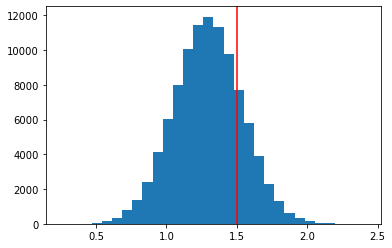

In [37]:
plt.hist(b0hat,bins=30)
plt.axvline(x=d0,color='red')
pass

$\hat{\beta}_1$の分布

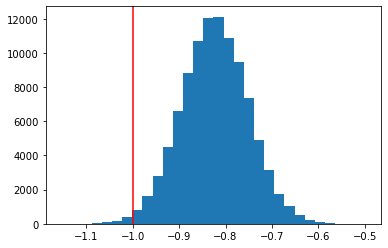

In [38]:
plt.hist(b1hat,bins=30)
plt.axvline(x=d1,color='red')
pass

$\hat{\beta}_2$の分布

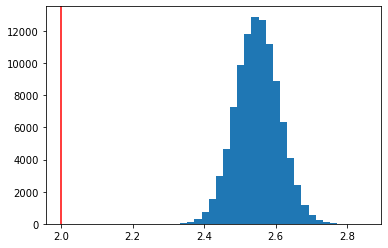

In [39]:
plt.hist(b2hat,bins=30)
plt.axvline(x=d2,color='red')
pass